In [1]:
import os
import sys

import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import tqdm
import numpy as np
import random

import warnings
warnings.filterwarnings("ignore")

In [2]:
class Config:
    ROOT_DIR = './data/huge'
    SEED = 42

CONFIG = Config()

In [3]:
seed = CONFIG.SEED
np.random.seed(seed)
random.seed(seed)

In [5]:
train_df = pd.read_csv(os.path.join(CONFIG.ROOT_DIR, "train_df.csv"), index_col='Serial Number')
test_x = pd.read_csv(os.path.join(CONFIG.ROOT_DIR, "test_x.csv"), index_col='Serial Number')
train_y = pd.read_csv(os.path.join(CONFIG.ROOT_DIR, "train_y.csv"), index_col='Serial Number')

In [7]:
train_df['TIMESTAMP'] = pd.to_datetime(train_df['TIMESTAMP'])
train_df['TIMESTAMP'] = train_df['TIMESTAMP'].map(lambda t: t.strftime('%Y-%m-%d %H:%M'))

test_x['TIMESTAMP'] = pd.to_datetime(test_x['TIMESTAMP'])
test_x['TIMESTAMP'] = test_x['TIMESTAMP'].map(lambda t: t.strftime('%Y-%m-%d %H:%M'))

serial_key = list(train_df.columns)[0]
date_time_key = list(train_df.columns)[1]
feature_keys = list(train_df.columns)[3:-1]
target_key = list(train_df.columns)[-1]

train_x = train_df.drop(columns='Y')

In [8]:
train_df.head(3)

,TIMESTAMP,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,Y
Serial Number,,,,,,,,,,,,,,,,,,,,
19,2020-02-09 16:24,EI83N072710203N8H,22,18,22,16,32,99,91219,43095,2132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19,2020-02-10 16:39,EI83N072710203N8H,22,18,22,16,32,99,91413,43214,2133,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
19,2020-02-11 16:54,EI83N072710203N8H,22,18,22,16,32,99,91606,43332,2135,49.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1


In [6]:
train_y.value_counts()

Y
0    7060
1    1212
dtype: int64

Fail 수가 더 적음


In [7]:
print("Train Data 크기 :", train_x.shape)
print("Test Data 크기 :", test_x.shape)

print("Train Data의 Serial Number의 unique 값 :", len(train_x[serial_key].unique()))
print("Test Data의 Serial Number의 unique 값 :", len(test_x[serial_key].unique()))

Train Data 크기 : (555456, 19)
Test Data 크기 : (138880, 19)
Train Data의 Serial Number의 unique 값 : 97860
Test Data의 Serial Number의 unique 값 : 72562


### PreProcessing

In [8]:
train_x.drop(columns='X1', inplace=True)
test_x.drop(columns='X1', inplace=True)

In [9]:
scaler = StandardScaler()
train_x[feature_keys] = scaler.fit_transform(train_df[feature_keys])
test_x[feature_keys] = scaler.transform(test_x[feature_keys])

In [10]:
train_x_by_serial = [group[1] for group in train_x.groupby(train_x.index)]
test_x_by_serial = [group[1] for group in test_x.groupby(test_x.index)]

train_x_by_serial = [group.sort_values('TIMESTAMP') for group in train_x_by_serial]
test_x_by_serial = [group.sort_values('TIMESTAMP') for group in test_x_by_serial]

In [11]:
train_x_by_serial[2].index.unique().item()

48

In [12]:
train_y.loc[54509]

Y    0
Name: 54509, dtype: int64

### 데이터의 길이 확인

In [13]:
len(train_x_by_serial)

8272

In [14]:
lens = [len(x) for x in train_x_by_serial]

(array([  35.,   37.,   25.,   34.,   29.,   53.,   87.,  103., 5212.,
        2657.]),
 array([53. , 54.6, 56.2, 57.8, 59.4, 61. , 62.6, 64.2, 65.8, 67.4, 69. ]),
 <BarContainer object of 10 artists>)

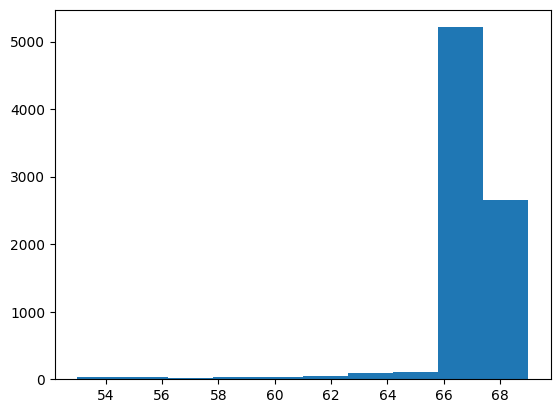

In [15]:
plt.hist(lens)

### 데이터 구성 확인

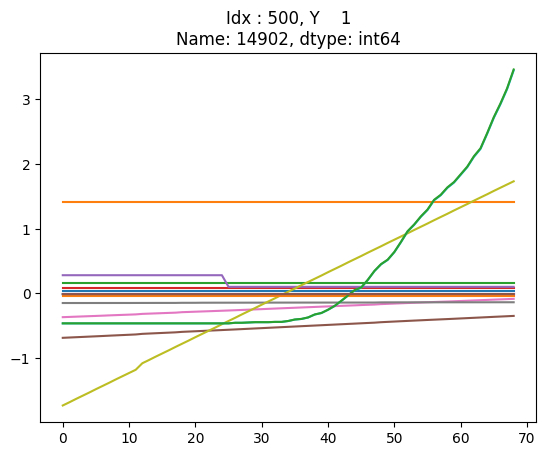

In [16]:
view = 500
for idx, feature in enumerate(feature_keys):
    plt.plot(list(train_x_by_serial[view][feature]))
plt.title(f'Idx : {view}, {train_y.iloc[view]}')
plt.show()

In [17]:
print(feature_keys)

['X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18']


In [18]:
train_x_by_serial[0].head(3)

,TIMESTAMP,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
Serial Number,,,,,,,,,,,,,,,,,,
19,2020-02-09 16:24,22,-0.131197,-0.328687,-1.188559,-0.159641,0.099822,0.369237,0.052918,-0.101300,-1.734490,-0.465737,-0.012637,-0.035175,-0.464819,-0.010677,-0.011952,-0.013366
19,2020-02-10 16:39,22,-0.131197,-0.328687,-1.188559,-0.159641,0.099822,0.373802,0.056632,-0.101255,-1.684896,-0.465737,-0.012637,-0.035175,-0.464819,-0.010677,-0.011952,-0.013366
19,2020-02-11 16:54,22,-0.131197,-0.328687,-1.188559,-0.159641,0.099822,0.378344,0.060313,-0.101165,-1.633236,-0.461173,-0.012637,-0.035175,-0.460239,-0.010677,-0.011952,-0.013366


## 데이터셋 생성

In [19]:
def train_test_split(Xs, ys, test_ratio=0.2):
    data_per_label = {}

    for x, y in zip(Xs, ys):
        label = y
        if label not in data_per_label:
            data_per_label[label] = []
        data_per_label[label].append((x, y))

    train = []
    test = []

    for label in data_per_label:
        data = data_per_label[label]
        n_test = int(len(data) * test_ratio)
        test += data[:n_test]
        train += data[n_test:]

    X_train, y_train = zip(*train)
    X_test, y_test = zip(*test)

    return X_train, X_test, y_train, y_test

In [20]:
X_train, X_val, y_train, y_val = train_test_split(train_x_by_serial, train_y['Y'], test_ratio=0.2)

In [21]:
X_train[0].head(3)

,TIMESTAMP,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18
Serial Number,,,,,,,,,,,,,,,,,,
5832,2020-02-09 23:53,25,-0.120935,-0.675886,-1.188559,0.313102,0.099822,0.626774,0.275547,-0.085231,-1.734490,-0.465737,-0.012637,-0.035175,-0.464819,-0.010677,-0.011952,-0.013366
5832,2020-02-11 00:08,25,-0.120935,-0.328687,-1.188559,0.313102,0.099822,0.630822,0.278886,-0.085231,-1.684896,-0.420095,-0.012637,-0.035175,-0.419026,-0.010677,-0.011952,-0.013366
5832,2020-02-12 00:23,25,-0.120935,-0.328687,-1.188559,0.313102,0.099822,0.634893,0.282256,-0.085186,-1.635302,-0.360761,-0.012637,-0.035175,-0.359496,-0.010677,-0.011952,-0.013366


In [22]:
X_train = [x.drop(columns='TIMESTAMP') for x in X_train]
X_val = [x.drop(columns='TIMESTAMP') for x in X_val]
X_test = [x.drop(columns='TIMESTAMP') for x in test_x_by_serial]

print("Train Data의 개수 :", len(X_train))
print("Validation Data의 개수 :", len(X_val))
print("Test Data의 개수 :", len(X_test))

Train Data의 개수 : 6618
Validation Data의 개수 : 1654
Test Data의 개수 : 2069


In [23]:
def align_data(data, series_length):
    data_features = [x[feature_keys] for x in data]
    len_data = len(data_features)
    length_aligned_X = [[] for _ in range(len_data)]
    for idx, x in enumerate(data_features):
        if len(x) >= series_length:
            length_aligned_X[idx].append(x.iloc[- series_length:].values)
        else:
            print(f'extended at index {idx}')
            last_value = x.iloc[-1].values
            extended_part = np.tile(last_value, (series_length - len(x), 1))
            aligned_series = np.concatenate([x.values, extended_part], axis=0)
            length_aligned_X[idx].append(aligned_series)
    
    return np.array(length_aligned_X).squeeze(axis=1)

In [24]:
series_length = 50

X_train_align_byFeature = align_data(X_train, series_length)
X_val_align_byFeature = align_data(X_val, series_length)
X_test_align_byFeature = align_data(X_test, series_length)

In [25]:
y_train = np.array(y_train)
y_val = np.array(y_val)

## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며 올바른 형식으로 `submission.csv`를 쓴다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로 간단한 의사 결정 트리 머신러닝 모델을 학습하는 과정입니다.

In [26]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [27]:
import xgboost
from xgboost import XGBClassifier
models = {}

In [28]:
for idx, feature in enumerate(feature_keys):
    model = XGBClassifier(random_state = seed)
    X_feature = X_train_align_byFeature[:, :, idx]
    model.fit(X_feature, y_train)
    models[feature] = model

In [29]:
scores={}

for idx, feature in enumerate(feature_keys):
    X_val_feature = X_val_align_byFeature[:, :, idx]
    y_val_pred = models[feature].predict(X_val_feature)
    
    f1 = f1_score(y_val, y_val_pred, average='macro')
    scores[feature] = f1
    print(f'{feature} F1 Score: {f1:.8f}')

X3 F1 Score: 0.46549021
X4 F1 Score: 0.67662411
X5 F1 Score: 0.58074001
X6 F1 Score: 0.46133060
X7 F1 Score: 0.48941269
X8 F1 Score: 0.59418286
X9 F1 Score: 0.53906111
X10 F1 Score: 0.65340101
X11 F1 Score: 0.59233245
X12 F1 Score: 0.90823925
X13 F1 Score: 0.51464482
X14 F1 Score: 0.46053490
X15 F1 Score: 0.89759071
X16 F1 Score: 0.46053490
X17 F1 Score: 0.46035889
X18 F1 Score: 0.53527722


<BarContainer object of 16 artists>

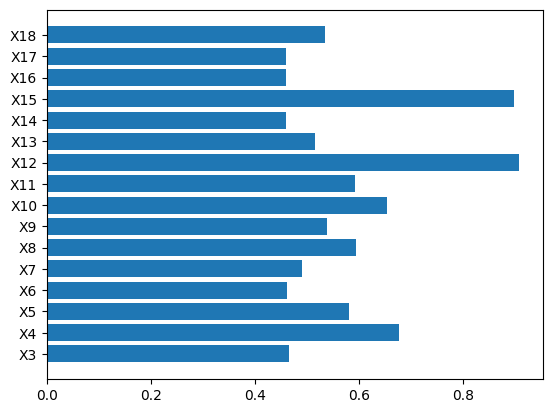

In [30]:
plt.barh(list(scores.keys()), scores.values())

In [31]:
selected_features = [feature for feature, score in scores.items() if score >= 0.5]
print(selected_features)

['X4', 'X5', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X15', 'X18']


### Pred

In [83]:
submission = pd.read_csv(os.path.join(CONFIG.ROOT_DIR, "test_y.csv"), index_col='Serial Number')

# 테스트 데이터에 대해 예측하고, 결과를 저장합니다.
y_test_pred = clf.predict(X_test_align)
submission["Y"] = y_test_pred
submission.to_csv("submission.csv", index_label='Serial Number')

### 결과 검증

`submission.csv` 파일을 다시 불러와 올바르게 값을 채웠는지 다시 한번 확인합니다.

In [84]:
submission = pd.read_csv("submission.csv", index_col='Serial Number')
submission

,Y
Serial Number,
100122I,1
100368G,0
101403L,0
101426G,0
101505B,0
...,...
997719U,0
998737L,0
999308S,0


In [85]:
# 예측 결과 중 1의 비율을 계산하고, 학습용 데이터의 비율과 비교합니다.
print(submission["Y"].mean())
print(train_y.mean())

0.18559690671822135
Y    0.146518
dtype: float64


//